# Finite Difference Formulas

**1st derivative:**  
Forward: $f'(x_i)\approx \frac{f_{i+1}-f_i}{h}$, Backward: $f'(x_i)\approx \frac{f_i-f_{i-1}}{h}$, Central: $f'(x_i)\approx \frac{f_{i+1}-f_{i-1}}{2h}$

**2nd derivative:**  
Forward: $f''(x_i)\approx \frac{f_{i+2}-2f_{i+1}+f_i}{h^2}$, Backward: $f''(x_i)\approx \frac{f_i-2f_{i-1}+f_{i-2}}{h^2}$, Central: $f''(x_i)\approx \frac{f_{i+1}-2f_i+f_{i-1}}{h^2}$

**3rd derivative:**  
Forward: $f'''(x_i)\approx \frac{-f_{i+3}+3f_{i+2}-3f_{i+1}+f_i}{h^3}$, Backward: $f'''(x_i)\approx \frac{f_i-3f_{i-1}+3f_{i-2}-f_{i-3}}{h^3}$, Central: $f'''(x_i)\approx \frac{f_{i+2}-2f_{i+1}+2f_{i-1}-f_{i-2}}{2h^3}$

**4th derivative:**  
Forward: $f''''(x_i)\approx \frac{f_{i+4}-4f_{i+3}+6f_{i+2}-4f_{i+1}+f_i}{h^4}$, Backward: $f''''(x_i)\approx \frac{f_i-4f_{i-1}+6f_{i-2}-4f_{i-3}+f_{i-4}}{h^4}$, Central: $f''''(x_i)\approx \frac{f_{i-2}-4f_{i-1}+6f_i-4f_{i+1}+f_{i+2}}{h^4}$

# EXAMPLE 10.34
Solve the equation $y'' = x + y$ with the boundary conditions $y(0) = y(1) = 0$.

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.001422 s

Training model...

0         [2.11e-01, 0.00e+00, 2.12e-02]    [2.11e-01, 0.00e+00, 2.12e-02]    []  
1000      [1.80e-03, 2.54e-06, 1.76e-05]    [1.80e-03, 2.54e-06, 1.76e-05]    []  
2000      [4.20e-05, 5.10e-08, 1.37e-08]    [4.20e-05, 5.10e-08, 1.37e-08]    []  
3000      [4.86e-05, 7.88e-07, 3.07e-05]    [4.86e-05, 7.88e-07, 3.07e-05]    []  
4000      [2.71e-05, 6.13e-10, 3.79e-09]    [2.71e-05, 6.13e-10, 3.79e-09]    []  
5000      [2.58e-05, 7.38e-10, 3.82e-09]    [2.58e-05, 7.38e-10, 3.82e-09]    []  
6000      [2.55e-05, 5.25e-08, 1.52e-06]    [2.55e-05, 5.25e-08, 1.52e-06]    []  
7000      [2.32e-05, 1.13e-09, 2.22e-09]    [2.32e-05, 1.13e-09, 2.22e-09]    []  
8000      [2.12e-05, 1.02e-09, 4.96e-1

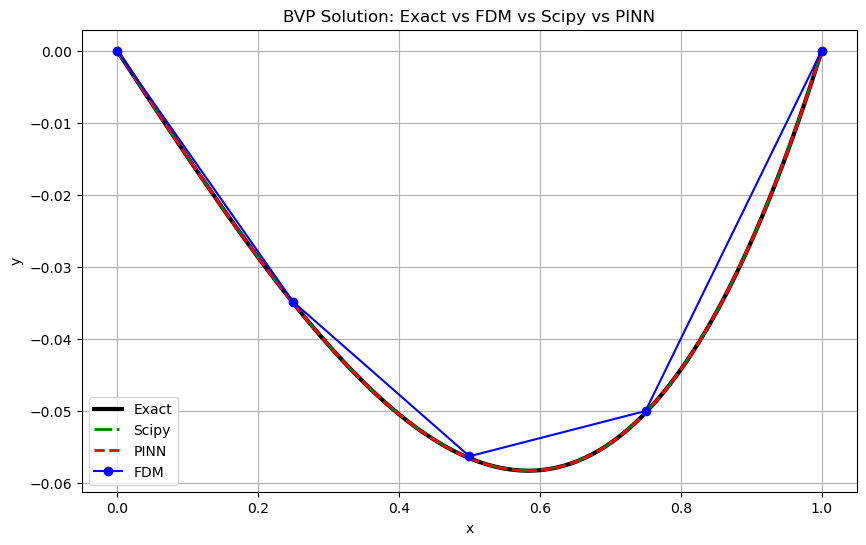

In [12]:
import deepxde as dde
import numpy as np
import sympy as sp
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
dde.backend.set_default_backend('pytorch')

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 2), x + y)
exact_sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 0, y.subs(x, 1): 0})
exact_sol_numc = sp.lambdify(x, exact_sol.rhs, 'numpy')

def ode_sys(x, y):
    return np.vstack((y[1] , x + y[0]))

def bc(ya, yb):
    return np.array([ya[0], yb[0]])

x_init = np.linspace(0, 1, 100)
y_init = np.zeros((2, x_init.size))
sol_scipy = solve_bvp(ode_sys, bc, x_init, y_init)

h = 0.25
x_vals = np.arange(0.25, 1, h)

A = np.zeros((3, 3))
for i in range(3):
    A[i, i] = 2 + h**2
    if i > 0:
        A[i, i-1] = -1
    if i < 2:
        A[i, i+1] = -1

b = -h**2*x_vals
y_fdm = np.linalg.solve(A, b)

x_fdm = np.linspace(0, 1, 5)
y_fdm2 = np.zeros(5)
y_fdm2[1:4] = y_fdm

geom = dde.geometry.Interval(0, 1)

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - x - y

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc2 = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1))

data = dde.data.PDE(geom, pde, [bc1, bc2], num_domain=100, num_boundary=2)

net = dde.nn.FNN([1, 64, 64, 64, 1], 'tanh', 'Glorot normal')

model = dde.Model(data, net)

model.compile('adam', lr=0.0005)
model.train(iterations=10000)

model.compile('L-BFGS')
model.train()

y_pinn = model.predict(x_vals.reshape(-1, 1))
y_scipy = sol_scipy.sol(x_vals)[0]
for xi, yi, zi, si, pi in zip(x_vals, exact_sol_numc(x_vals), y_fdm, y_scipy, y_pinn):
    print(f'x = {xi:.2f}, y_exact = {yi:.6f}, y_fdm = {zi:.6f}, y_scipy = {si:.6f}, y_pinn = {pi[0]:.6f}')

x_plot = np.linspace(0, 1, 200).reshape(-1, 1)
y_pinn2 = model.predict(x_plot.reshape(-1, 1))
plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_sol_numc(x_plot), 'k-', label='Exact', linewidth=3)
plt.plot(x_plot, sol_scipy.sol(x_plot)[0], 'g-.', label='Scipy', linewidth=2)
plt.plot(x_plot, y_pinn2, 'r--', label='PINN', linewidth=2)
plt.plot(x_fdm, y_fdm2, 'bo-', label='FDM')
plt.title('BVP Solution: Exact vs FDM vs Scipy vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

Iter 0, Loss = 6.249e-01
Iter 1000, Loss = 5.977e-05
Iter 2000, Loss = 5.134e-06
Iter 3000, Loss = 2.203e-06
Iter 4000, Loss = 1.184e-06
Iter 5000, Loss = 9.129e-07
Iter 6000, Loss = 8.199e-05
Iter 7000, Loss = 8.155e-07
Iter 8000, Loss = 8.592e-07
Iter 9000, Loss = 8.985e-07
x=0.25, Exact=-0.035048, FDM=-0.034885, SciPy=-0.035048, PINN=-0.035048
x=0.50, Exact=-0.056591, FDM=-0.056326, SciPy=-0.056591, PINN=-0.056600
x=0.75, Exact=-0.050276, FDM=-0.050037, SciPy=-0.050276, PINN=-0.050287


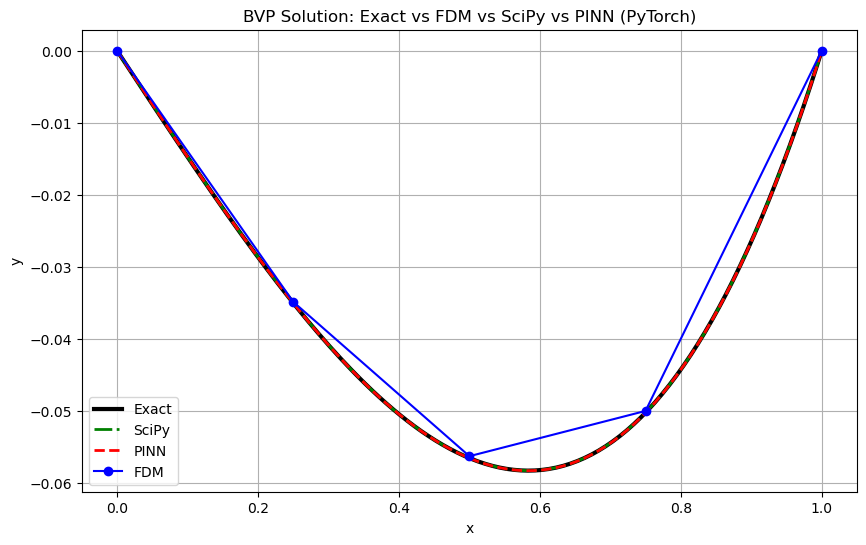

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sympy as sp
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# ------------------------
# Exact solution (SymPy)
# ------------------------
x_sym = sp.Symbol('x')
y_sym = sp.Function('y')(x_sym)
ode = sp.Eq(sp.diff(y_sym, x_sym, 2), x_sym + y_sym)
exact_sol = sp.dsolve(ode, y_sym, ics={y_sym.subs(x_sym,0):0, y_sym.subs(x_sym,1):0})
exact_num = sp.lambdify(x_sym, exact_sol.rhs, 'numpy')

# ------------------------
# SciPy solve_bvp
# ------------------------
def ode_sys(x, y):
    return np.vstack((y[1], x + y[0]))

def bc(ya, yb):
    return np.array([ya[0], yb[0]])

x_init = np.linspace(0,1,100)
y_init = np.zeros((2, x_init.size))
sol_scipy = solve_bvp(ode_sys, bc, x_init, y_init)

# ------------------------
# FDM
# ------------------------
h = 0.25
x_vals = np.arange(0.25,1,h)
A = np.zeros((3,3))
for i in range(3):
    A[i,i] = 2 + h**2
    if i>0:
        A[i,i-1] = -1
    if i<2:
        A[i,i+1] = -1
b = -h**2 * x_vals
y_fdm = np.linalg.solve(A,b)

x_fdm = np.linspace(0,1,5)
y_fdm2 = np.zeros(5)
y_fdm2[1:4] = y_fdm

# ------------------------
# PINN using PyTorch
# ------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Network definition
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

# Training data (collocation points)
N_domain = 100
x_colloc = torch.linspace(0,1,N_domain,device=device).view(-1,1)
x_colloc.requires_grad = True

# Boundary points
x_bc = torch.tensor([[0.0],[1.0]], device=device)
y_bc = torch.tensor([[0.0],[0.0]], device=device)

# Model and optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Loss function
def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_colloc, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    f = d2y - x_colloc - y
    loss_domain = torch.mean(f**2)
    # boundary loss
    y_b = model(x_bc)
    loss_bc = torch.mean((y_b - y_bc)**2)
    return loss_domain + loss_bc

# Training loop
for it in range(10000):
    optimizer.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer.step()
    if it % 1000 == 0:
        print(f'Iter {it}, Loss = {loss.item():.3e}')

# Optional: L-BFGS fine-tuning
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss

optimizer_lbfgs.step(closure)

# ------------------------
# Predictions
# ------------------------
x_vals_torch = torch.tensor(x_vals.reshape(-1,1), device=device, dtype=torch.float32)
y_pinn = model(x_vals_torch).detach().cpu().numpy()
y_scipy_vals = sol_scipy.sol(x_vals)[0]
y_exact_vals = exact_num(x_vals)

# Print comparison
for xi, ye, yf, ys, yp in zip(x_vals, y_exact_vals, y_fdm, y_scipy_vals, y_pinn):
    print(f"x={xi:.2f}, Exact={ye:.6f}, FDM={yf:.6f}, SciPy={ys:.6f}, PINN={yp[0]:.6f}")

# ------------------------
# Plotting
# ------------------------
x_plot = np.linspace(0,1,200).reshape(-1,1)
y_pinn_plot = model(torch.tensor(x_plot, dtype=torch.float32, device=device)).detach().cpu().numpy()
y_scipy_plot = sol_scipy.sol(x_plot.flatten())[0]
y_exact_plot = exact_num(x_plot)

plt.figure(figsize=(10,6))
plt.plot(x_plot, y_exact_plot, 'k-', linewidth=3, label='Exact')
plt.plot(x_plot, y_scipy_plot, 'g-.', linewidth=2, label='SciPy')
plt.plot(x_plot, y_pinn_plot, 'r--', linewidth=2, label='PINN')
plt.plot(x_fdm, y_fdm2, 'bo-', label='FDM')
plt.xlabel('x')
plt.ylabel('y')
plt.title('BVP Solution: Exact vs FDM vs SciPy vs PINN (PyTorch)')
plt.grid(True)
plt.legend()
plt.show()

Iter 0, Loss = 2.414e-01


Iter 1000, Loss = 7.214e-06
Iter 2000, Loss = 3.069e-06
Iter 3000, Loss = 1.516e-06
Iter 4000, Loss = 6.249e-07
Iter 5000, Loss = 5.715e-07
Iter 6000, Loss = 3.099e-07
Iter 7000, Loss = 6.515e-07
Iter 8000, Loss = 3.273e-07
Iter 9000, Loss = 7.116e-07
x=0.25, Exact=-0.035048, PINN=-0.035043
x=0.50, Exact=-0.056591, PINN=-0.056591
x=0.75, Exact=-0.050276, PINN=-0.050279


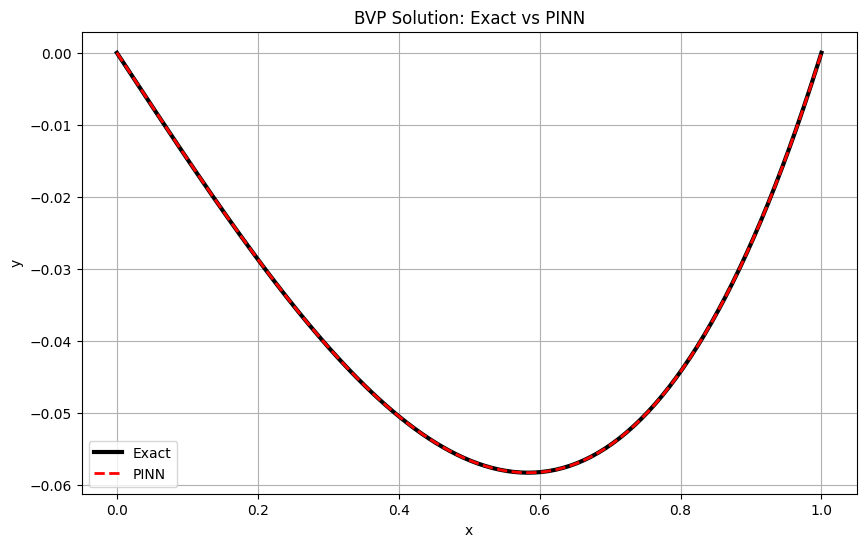

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 2), x + y)

exact_sol = sp.dsolve(ode, y, ics=({y.subs(x, 0): 0, y.subs(x, 1): 0}))
exact_sol_func = sp.lambdify(x, exact_sol.rhs, 'numpy')
h = 0.25
x_vals = np.arange(0.25, 1, h)
y_exact = exact_sol_func(x_vals)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 1))
    def forward(self, x):
        return self.net(x)
    

x_colloc = torch.linspace(0, 1, 100, device=device, dtype=torch.float64, requires_grad=True).reshape(-1, 1)

x_bc = torch.tensor([[0.0], [1.0]], device=device, dtype=torch.float64)
y_bc = torch.tensor([[0.0], [0.0]], device=device, dtype=torch.float64)

model = PINN().to(device).double()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_colloc, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    f = d2y - x_colloc - y
    loss_domain = torch.mean(f**2)
    y_b = model(x_bc)
    loss_bc = torch.mean((y_b - y_bc)**2)
    return loss_domain + loss_bc

for it in range(10000):
    optimizer.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer.step()
    if it % 1000 == 0:
        print(f'Iter {it}, Loss = {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss

optimizer_lbfgs.step(closure)

x_vals_torch = torch.tensor(x_vals.reshape(-1, 1), device=device, dtype=torch.float64)
y_pinn = model(x_vals_torch).detach().cpu().numpy()

for xi, yi, pi in zip(x_vals, y_exact, y_pinn):
    print(f'x={xi:.2f}, Exact={yi:.6f}, PINN={pi[0]:.6f}')

x_plot = np.linspace(0, 1, 200).reshape(-1, 1)
y_pinn_plot = model(torch.tensor(x_plot, device=device, dtype=torch.float64)).detach().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_sol_func(x_plot), 'k-', label='Exact', linewidth=3)
plt.plot(x_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.grid(True)
plt.title('BVP Solution: Exact vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# EXAMPLE 10.35
Using the finite difference method, find $y(0.25)$, $y(0.5)$, and $y(0.75)$ satisfying the differential equation $\frac{dy}{dx} = x - y$ subject to the boundary conditions $y(0) = 0, y(1) = 2$

Iter 0, Loss = 1.980e+00
Iter 1000, Loss = 3.828e-06
Iter 2000, Loss = 9.521e-07
Iter 3000, Loss = 5.826e-07
Iter 4000, Loss = 2.609e-07
Iter 5000, Loss = 8.522e-08
Iter 6000, Loss = 4.924e-08
Iter 7000, Loss = 4.503e-08
Iter 8000, Loss = 4.270e-08
Iter 9000, Loss = 4.232e-08
x=0.25, Exact=0.544014, FDM=0.544274, PINN=0.544014
x=0.50, Exact=1.069747, FDM=1.070156, PINN=1.069753
x=0.75, Exact=1.560056, FDM=1.560403, PINN=1.560057


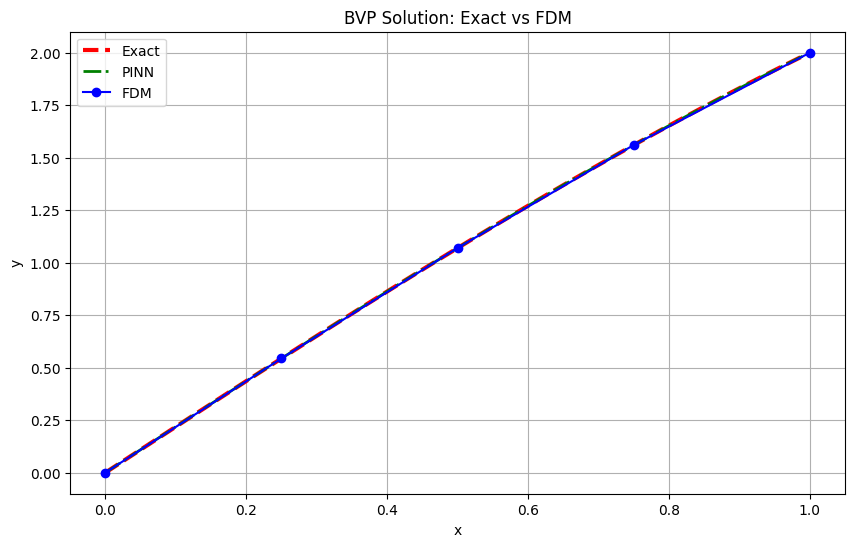

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 2), x - y)
exact_sol = sp.dsolve(ode, y, ics=({y.subs(x, 0): 0, y.subs(x, 1): 2}))
exact_func = sp.lambdify(x, exact_sol.rhs, 'numpy')

h = 0.25
x_vals = np.arange(0.25, 1, h)

A = np.zeros((3, 3))
for i in range(3):
    A[i, i] = 2 - h**2
    if i > 0:
        A[i, i-1] = -1
    if i < 2:
        A[i, i+1] = -1

b = np.array([-h**2*0.25, -h**2*0.5, 2-h**2*0.75])
y_fdm = np.linalg.solve(A, b)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 1))
    def forward(self, x):
        return self.net(x)
    
x_colloc = torch.linspace(0, 1, 100, device=device, dtype=torch.float64, requires_grad=True).reshape(-1, 1)

x_bc = torch.tensor([[0.0], [1.0]], device=device, dtype=torch.float64)
y_bc = torch.tensor([[0.0], [2.0]], device=device, dtype=torch.float64)

model = PINN().to(device).double()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_colloc, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    f = d2y + y - x_colloc
    loss_domain = torch.mean(f**2)
    y_b = model(x_bc)
    loss_bc = torch.mean((y_b - y_bc)**2)
    return loss_domain + loss_bc

for it in range(10000):
    optimizer.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer.step()
    if it % 1000 == 0:
        print(f'Iter {it}, Loss = {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_vals_torch = torch.tensor(x_vals.reshape(-1, 1), device=device, dtype=torch.float64)
y_pinn = model(x_vals_torch).detach().cpu().numpy()
for xi, yi, zi, pi in zip(x_vals, exact_func(x_vals), y_fdm, y_pinn):
    print(f'x={xi:.2f}, Exact={yi:.6f}, FDM={zi:.6f}, PINN={pi[0]:.6f}')

x_plot = np.linspace(0, 1, 100)
x_fdm = np.linspace(0, 1, 5)
y_fdm2 = np.zeros(5)
y_fdm2[1:4] = y_fdm
y_fdm2[4] = 2
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), device=device, dtype=torch.float64)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_func(x_plot), 'r--', label='Exact', linewidth=3)
plt.plot(x_plot, y_pinn_plot, 'g-.', label='PINN', linewidth=2)
plt.plot(x_fdm, y_fdm2, 'bo-', label='FDM')
plt.title('BVP Solution: Exact vs FDM')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# EXAMPLE 10.36
Determine values of $y$ at the pivotal points of the interval $(0, 1)$ if $y$ satisfies the boundary value problem $y^{iv} + 81y = 81x^2, y(0) = y(1) = y''(0) = y''(1) = 0$. (Take n = 3).

Adam Iter 0, Loss 7.392e+02
Adam Iter 1000, Loss 4.455e-01
Adam Iter 2000, Loss 7.463e-02
Adam Iter 3000, Loss 2.473e-02
Adam Iter 4000, Loss 1.275e-02
Adam Iter 5000, Loss 7.948e-03
Adam Iter 6000, Loss 4.968e-03
Adam Iter 7000, Loss 3.715e-03
Adam Iter 8000, Loss 2.394e-03
Adam Iter 9000, Loss 1.971e-03
x=0.33, Exact=0.135562, FDM=0.122222, PINN=0.135564
x=0.67, Exact=0.161927, FDM=0.155556, PINN=0.161927


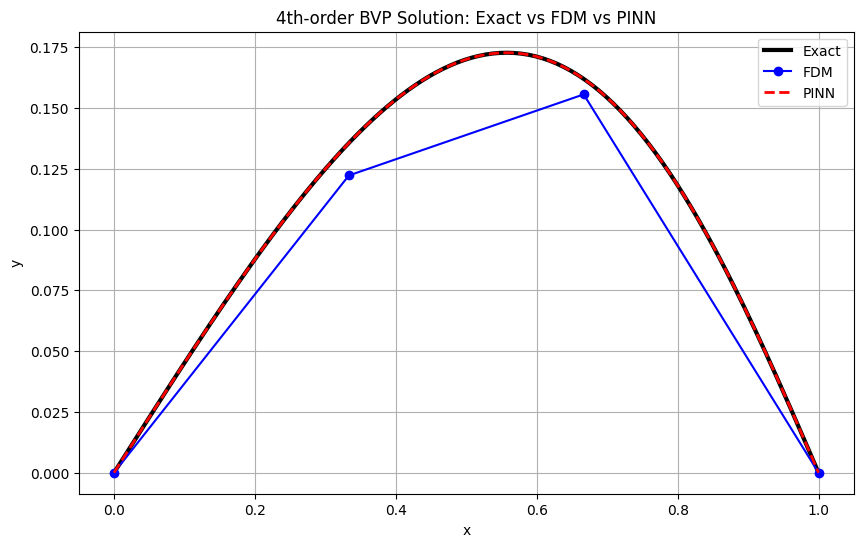

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. Symbolic Exact Solution
# ===============================
x = sp.Symbol('x')
y = sp.Function('y')(x)

# 4th-order ODE: y'''' + 81y = 81 x^2
ode = sp.Eq(sp.diff(y, x, 4), -81*y + 81*x**2)

# Boundary conditions: y(0)=y(1)=y''(0)=y''(1)=0
sol = sp.dsolve(ode, y, ics={
    y.subs(x, 0): 0,
    y.subs(x, 1): 0,
    sp.diff(y, x, 2).subs(x, 0): 0,
    sp.diff(y, x, 2).subs(x, 1): 0
})

exact_func = sp.lambdify(x, sol.rhs, 'numpy')

x_vals = np.linspace(0, 1, 4)

# ===============================
# 2. Simple FDM Solution
# ===============================
A = np.array([[6, -4],
              [-4, 6]])
b = np.array([1/9, 4/9])
y_fdm = np.linalg.solve(A, b)

# ===============================
# 3. Define PINN
# ===============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device).double()

# Collocation points for PDE residual
x_colloc = torch.linspace(0, 1, 100, dtype=torch.float64, device=device, requires_grad=True).reshape(-1, 1)
# Boundary points
x0 = torch.tensor([[0.0]], dtype=torch.float64, device=device, requires_grad=True)
xn = torch.tensor([[1.0]], dtype=torch.float64, device=device, requires_grad=True)

# ===============================
# 4. PINN Loss
# ===============================
def pinn_loss(bc_weight=100.0):
    # PDE residual
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_colloc, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    d3y = torch.autograd.grad(d2y, x_colloc, grad_outputs=torch.ones_like(d2y), create_graph=True)[0]
    d4y = torch.autograd.grad(d3y, x_colloc, grad_outputs=torch.ones_like(d3y), create_graph=True)[0]

    f = d4y + 81*y_pred - 81*x_colloc**2
    loss_pde = torch.mean(f**2)

    # Boundary conditions
    y0 = model(x0)
    yn = model(xn)

    dy0 = torch.autograd.grad(y0, x0, grad_outputs=torch.ones_like(y0), create_graph=True)[0]
    d2y0 = torch.autograd.grad(dy0, x0, grad_outputs=torch.ones_like(dy0), create_graph=True)[0]

    dyn = torch.autograd.grad(yn, xn, grad_outputs=torch.ones_like(yn), create_graph=True)[0]
    d2yn = torch.autograd.grad(dyn, xn, grad_outputs=torch.ones_like(dyn), create_graph=True)[0]

    loss_bc = (y0**2 + yn**2 + d2y0**2 + d2yn**2)
    return loss_pde + bc_weight * loss_bc

# ===============================
# 5. Optimizers: Adam + LBFGS
# ===============================
optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

# Pretrain with Adam
for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss(bc_weight=100.0)
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

# Refine with LBFGS
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss(bc_weight=100.0)
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

# ===============================
# 6. Predictions
# ===============================
x_pinn = torch.tensor(x_vals[1:3].reshape(-1,1), dtype=torch.float64, device=device)
y_pinn = model(x_pinn).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(x_vals[1:3], exact_func(x_vals[1:3]), y_fdm, y_pinn):
    print(f'x={xi:.2f}, Exact={yi:.6f}, FDM={zi:.6f}, PINN={pi:.6f}')

# ===============================
# 7. Plot
# ===============================
x_plot = np.linspace(0, 1, 200).reshape(-1, 1)
x_plot_torch = torch.tensor(x_plot, dtype=torch.float64, device=device)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy()

y_fdm2 = np.zeros(4)
y_fdm2[1:3] = y_fdm

plt.figure(figsize=(10,6))
plt.plot(x_plot, exact_func(x_plot), 'k-', label='Exact', linewidth=3)
plt.plot(x_vals, y_fdm2, 'bo-', label='FDM')
plt.plot(x_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.grid(True)
plt.title('4th-order BVP Solution: Exact vs FDM vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Adam Iter 0, Loss 1.527e+03
Adam Iter 1000, Loss 4.879e+01
Adam Iter 2000, Loss 8.460e-03
Adam Iter 3000, Loss 5.053e-03
Adam Iter 4000, Loss 3.259e-03
Adam Iter 5000, Loss 2.132e-03
Adam Iter 6000, Loss 4.069e-03
Adam Iter 7000, Loss 9.121e-04
Adam Iter 8000, Loss 3.842e-03
Adam Iter 9000, Loss 6.117e-01
x=0.33, Exact=0.135562, PINN=0.135574
x=0.67, Exact=0.161927, PINN=0.161933


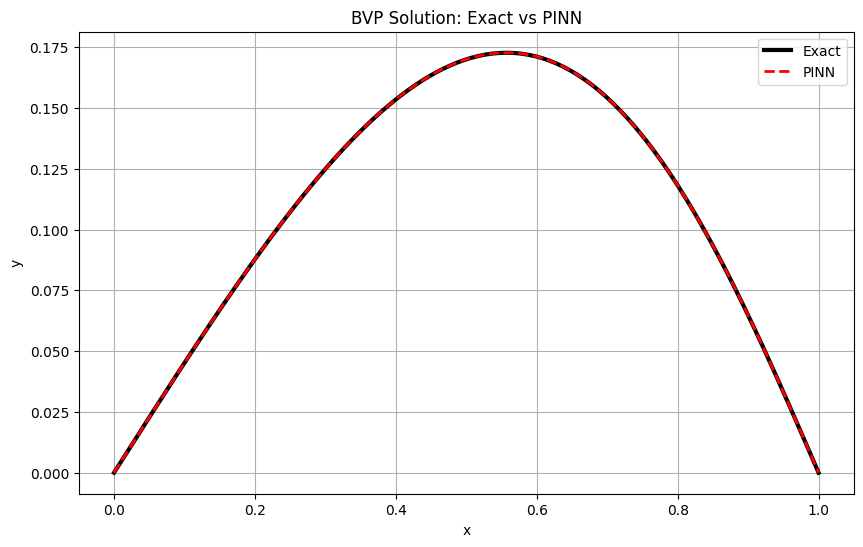

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# ===================================
# 1. Exact Solution
# ===================================
x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 4), -81*y + 81*x**2)
sol = sp.dsolve(ode, y, ics={y.subs(x,0): 0, y.subs(x, 1): 0, sp.diff(y, x, 2).subs(x, 0): 0, sp.diff(y, x, 2).subs(x, 1): 0})
exact_func = sp.lambdify(x, sol.rhs, 'numpy')

x_vals = np.linspace(0, 1, 4)

# ===================================
# 2. PINN
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device).double()

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float64, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float64, device=device, requires_grad=True)
xn = torch.tensor([1.0], dtype=torch.float64, device=device, requires_grad=True)

def pinn_loss(bc_weight=100.0):
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_colloc, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    d3y = torch.autograd.grad(d2y, x_colloc, grad_outputs=torch.ones_like(d2y), create_graph=True)[0]
    d4y = torch.autograd.grad(d3y, x_colloc, grad_outputs=torch.ones_like(d3y), create_graph=True)[0]
    f = d4y + 81*y - 81*x_colloc**2
    loss_pde = torch.mean(f**2)

    y0 = model(x0)
    yn = model(xn)
    dy0 = torch.autograd.grad(y0, x0, grad_outputs=torch.ones_like(y0), create_graph=True)[0]
    d2y0 = torch.autograd.grad(dy0, x0, grad_outputs=torch.ones_like(dy0), create_graph=True)[0]
    dyn = torch.autograd.grad(yn, xn, grad_outputs=torch.ones_like(yn), create_graph=True)[0]
    d2yn = torch.autograd.grad(dyn, xn, grad_outputs=torch.ones_like(dyn), create_graph=True)[0]

    loss_bc = y0**2 + yn**2 + d2y0**2 + d2yn**2
    return loss_pde + bc_weight * loss_bc

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss(bc_weight=100.0)
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss(bc_weight=100.0)
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.tensor(x_vals[1:3].reshape(-1, 1), dtype=torch.float64, device=device)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(x_vals[1:3], exact_func(x_vals[1:3]), y_pinn):
    print(f'x={xi:.2f}, Exact={yi:.6f}, PINN={pi:.6f}')

# ===================================
# 4. Plot
# ===================================
x_plot = np.linspace(0, 1, 200).reshape(-1, 1)
x_pinn2 = torch.tensor(x_plot, dtype=torch.float64, device=device)
y_plot = model(x_pinn2).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_func(x_plot), 'k-', label='Exact', linewidth=3)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('BVP Solution: Exact vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()